C:/Users/mvmigem/Documents/data/project_1/localiser_dat\loc_12.bdf
Extracting EDF parameters from C:\Users\mvmigem\Documents\data\project_1\localiser_dat\loc_12.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 176639  =      0.000 ...   344.998 secs...
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'eye_above', 'eye_below', 'eye_left', 'eye_right', 'M1', 'M2', 'Status']
<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 66 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 85.33 Hz
- Upper transition bandwidth: 21.33 Hz (-6 dB cutoff frequency: 96.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s


Effective window size : 4.000 (s)


[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    0.4s finished


Using matplotlib as 2D backend.


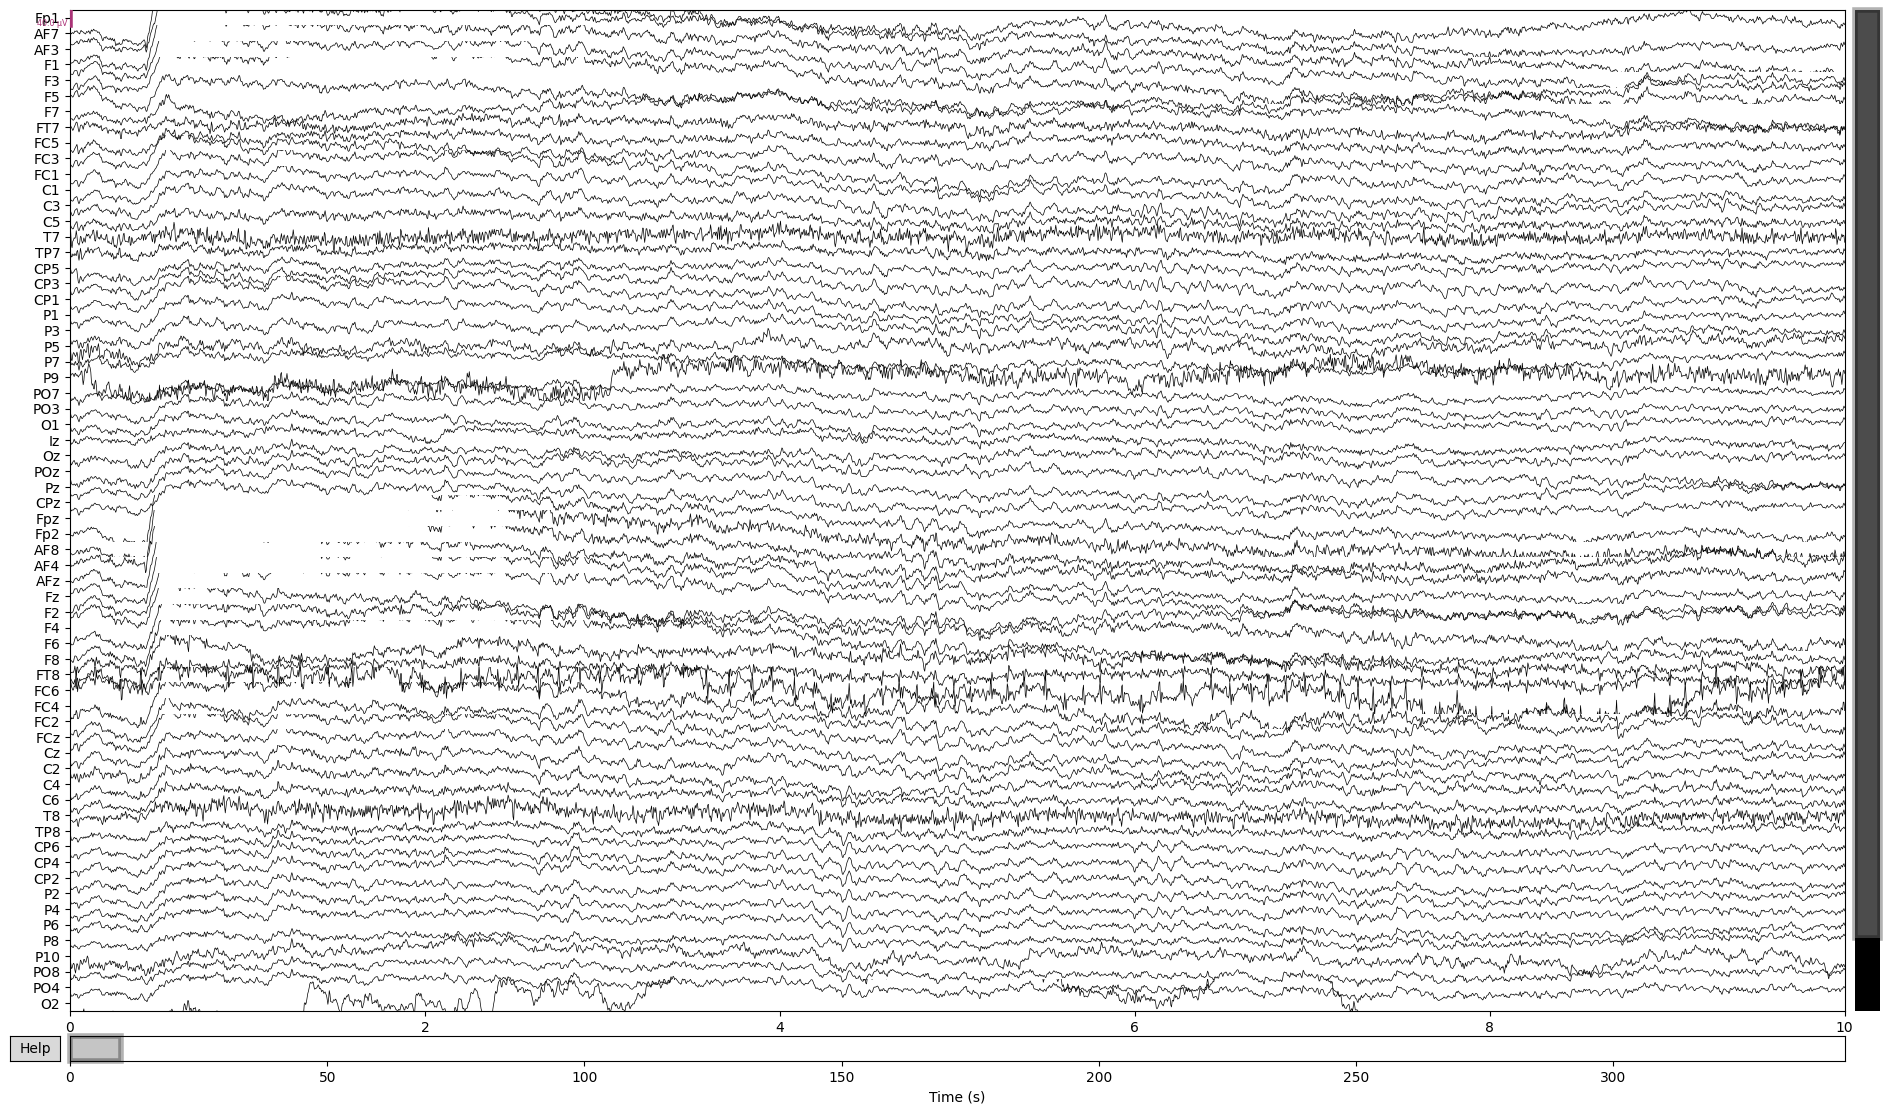

Channels marked as bad:
none


In [1]:
"""
EEG preprocessing
Meant for online processing of optimal C1 localization task
should be as fast as possible to select online 

Written by Maximilien Van Migem 

Created on 24/01/2024 
"""

# Import some libraries
import os
import numpy as np
import mne
import glob
import os
%matplotlib qt 

# Import data file
data_directory = 'C:/Users/mvmigem/Documents/data/project_1/localiser_dat/'
dir_list = glob.glob(data_directory+'*')
current_file_path = max(dir_list, key=os.path.getctime)
print(current_file_path)

raw = mne.io.read_raw_bdf(current_file_path, preload = True)

# Rename and adress channels

fix_chans = {'EXG1':'eye_above','EXG2':'eye_below',
             'EXG3':'eye_left','EXG4':'eye_right',
             'EXG5':'M1','EXG6':'M2'}
raw.rename_channels(fix_chans)

# we still have two exg channels which weren't actually recorded though (EXG7
# and EXG8) these are empty, so we'll drop them
raw.drop_channels(['EXG7', 'EXG8'])
print(raw.info['ch_names'])

# we'll also reset the channel types, so MNE knows what is 'brain' data
raw.set_channel_types({'M1':'eeg', 'M2':'eeg',
                       'eye_above':'eog', 'eye_below':'eog',
                       'eye_left':'eog', 'eye_right': 'eog'})

print(raw.info)

# Rereference to mastoids
raw.set_eeg_reference(ref_channels = ['M1','M2'])
# then drop them
raw.drop_channels(['M1','M2'])

# Select montage
montage = mne.channels.make_standard_montage('biosemi64')

# There is a mismatch between the names of the recording and the names of the montage
# This dict is to rename the channel names to fit the montage
mon_chnames = montage.ch_names
raw_chnames = raw.info['ch_names']
rename_channels = dict(zip(raw_chnames[:64],mon_chnames))
raw.rename_channels(rename_channels)

# Set montage
raw.set_montage(montage)

# Downsampling variables (logic -> https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#best-practices)
current_sfreq = raw.info['sfreq']
desired_sfreq = 256  # Hz
decim = np.round(current_sfreq / desired_sfreq).astype(int)
obtained_sfreq = current_sfreq / decim
lowpass_freq = obtained_sfreq / 3.


raw_filtered = raw.copy().notch_filter(freqs = 50, fir_design = 'firwin', verbose=None,n_jobs=-1)
raw_filtered = raw_filtered.copy().filter(l_freq=0.1, h_freq=lowpass_freq,n_jobs=-1)


# Plot to reject bad channels manually
raw_filtered.compute_psd().plot()
raw_filtered.plot(n_channels=64)

In [2]:
# Then intepolate bad channels
interp_filt_raw = raw_filtered.copy().interpolate_bads(reset_bads = True)

# Annotate events
events = mne.find_events(interp_filt_raw)
# Event dict
event_id = {        # This needs to be short in the online preprocess only 4 trigger markers (4 quads)
    'position1':80,'position2':81, 'position3':82,'position4':83, 
}

# Eye artifact rejection
almost_clean = interp_filt_raw.copy()

# we can also identify eog events algorithmically via "find_eog_events" this
# produces a list of 'events' around each blink (hopefully). This applies a 
# filter and then identifies peaks in the eog to find likely blinks. We can 
# adjust the threshold, via thresh. but default should be okay for now.
eog_events = mne.preprocessing.find_eog_events(almost_clean)
# we'll say that the blinks start a tiny bit earlier than 
onsets = eog_events[:, 0] / almost_clean.info["sfreq"] - 0.25
# we'll assume they're all half a second long
dur = [0.5] * len(eog_events)
descriptions = ["bad blink"] * len(eog_events)
blink_annot = mne.Annotations(onsets,
                              dur,
                              descriptions,
                              orig_time = almost_clean.info["meas_date"])
almost_clean.set_annotations(blink_annot)

# Epoch the data
epochs_stimlock = mne.Epochs(almost_clean, events, event_id = event_id,
    tmin = -0.1, tmax = 0.5, proj = False, baseline = (None,0), decim=decim, #from previous cell
    detrend = None, verbose = True, reject_by_annotation= True, preload = True)

# Evoked objects
evoked_pos1 = epochs_stimlock['position1'].average()
evoked_pos2 = epochs_stimlock['position2'].average()
evoked_pos3 = epochs_stimlock['position3'].average()
evoked_pos4 = epochs_stimlock['position4'].average()

evokeds_list = [evoked_pos1,evoked_pos2,evoked_pos3,evoked_pos4]
conds = ('position1','position2','position3','position4')
evoked_pos = dict(zip(conds, evokeds_list))

# Plot it all
epoch_set1 = evoked_pos
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'Pz', vlines=[0.05,0.1],ylim=dict(eeg=[-10, 10]))
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'POz', vlines=[0.05,0.1],ylim=dict(eeg=[-10, 10]))
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'Oz', vlines=[0.05,0.1],ylim=dict(eeg=[-10, 10]))


Trigger channel has a non-zero initial value of 65540 (consider using initial_event=True to detect this event)
241 events found
Event IDs: [   80    81    82    83 65789 65791]
Using EOG channels: eye_above, eye_below, eye_left, eye_right
EOG channel index for this subject is: [64 65 66 67]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel eye_above for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 21 significant peaks
Number of E

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_5336\1611132161.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  interp_filt_raw = raw_filtered.copy().interpolate_bads(reset_bads = True)


Not setting metadata
239 matching events found
Setting baseline interval to [-0.09765625, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 239 events and 308 original time points (prior to decimation) ...
5 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\mvmigem\AppData\Local\Temp\ipykernel_5336\1611132161.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  almost_clean.set_annotations(blink_annot)


[<Figure size 800x600 with 2 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'POz', vlines=[0.05,0.1],ylim=dict(eeg=[-6, 6]))
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'PO3', vlines=[0.05,0.1],ylim=dict(eeg=[-6, 6]))
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'PO4', vlines=[0.05,0.1],ylim=dict(eeg=[-6, 6]))
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'P1', vlines=[0.05,0.1],ylim=dict(eeg=[-6, 6]))
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'P2', vlines=[0.05,0.1],ylim=dict(eeg=[-6, 6]))
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'O1', vlines=[0.05,0.1],ylim=dict(eeg=[-6, 6]))
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'O2', vlines=[0.05,0.1],ylim=dict(eeg=[-6, 6]))

In [ ]:
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'Pz', vlines=[0.05,0.1],ylim=dict(eeg=[-10, 10]))
mne.viz.plot_compare_evokeds(epoch_set1, picks= 'POz', vlines=[0.05,0.1],ylim=dict(eeg=[-10, 10]))
